In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import os
import requests
import s3fs
from pprint import pprint
import pandas as pd
import boto3,tqdm
import numpy as np
import xarray as xr
import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
import rioxarray,cartopy
from cartopy.feature import ShapelyFeature,GSHHSFeature
from pystac_client import Client
from concurrent.futures import ThreadPoolExecutor




CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

In [2]:
provider = 'POCLOUD'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 200,
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )

In [3]:
response.headers['CMR-Hits']

'251'

In [4]:
collections = response.json()['feed']['entry']
for collection in collections:
    
    ID=f'{collection["archive_center"]} {collection["dataset_id"]} {collection["id"]}'
    if "Sentinel" in ID:
        print(ID)
        


NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L2 P4 Altimeter Low Resolution (LR) NRT Ocean Surface Topography C1968979597-POCLOUD
NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L2 P4 Altimeter Low Resolution (LR) STC Ocean Surface Topography C1968980609-POCLOUD
NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L2 P4 Altimeter Low Resolution (LR) NTC Ocean Surface Topography (Unvalidated) C1968979551-POCLOUD
NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L1B P4 Altimeter Low Resolution (LR) NTC Geolocated Waveforms C1968979582-POCLOUD
NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L1B P4 Altimeter Low Resolution (LR) STC Geolocated Waveforms C1968980593-POCLOUD
NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L1B GNSS-RO-POD Tracking Data Hourly C1968980589-POCLOUD
NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L2 P4 Altimeter Low Resolution (LR) NRT Reduced Ocean Surface Topography C1968980576-POCLOUD
NASA/JPL/PODAAC Sentinel-6A MF Jason-CS L2 P4 Altimeter Low Resolution (LR) NTC Reduced Ocean Surface Topography (Unvalidated) C196897953

In [5]:
url = f'{CMR_OPS}/{"granules"}'

In [6]:
lats = slice(32.0,38.0)
lons = slice(-131.0,-121.0)


response = requests.get(url, 
                        params={
                            'concept_id': 'C1968980609-POCLOUD',
                          #   'temporal': '2021-01-01T00:00:00Z,2021-01-03T23:59:59Z',
                            'bounding_box': f'{lons.start},{lats.start},{lons.stop},{lats.stop}',
                        #    'bounding_box': '-180.0,20.0,-100.0,50.0',
                           # 'page_size': 2,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
162


In [7]:
granules = response.json()['feed']['entry']
#for granule in granules:
#    for link in granule['links']:
#        if link['rel'].endswith('/data#'):
#            urls.append(link['href'])
#            break
#pprint(urls)
variables = ['data_01_time',
             'data_01_longitude',
             'data_01_latitude',
             'data_01_ku_ssha']
v = ",".join(variables)
glist = []
print(type(glist))
for gr in granules:
     for link in gr['links']:
        if link['href'].startswith('https://opendap'):
            tmp=f"{link['href']}.nc4?{v}"
            glist.append(tmp)
            break
     print(glist[-1])


<class 'list'>
https://opendap.earthdata.nasa.gov/collections/C1968980609-POCLOUD/granules/S6A_P4_2__LR_STD__ST_022_221_20210622T114735_20210622T124348_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980609-POCLOUD/granules/S6A_P4_2__LR_STD__ST_022_232_20210622T220557_20210622T230210_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980609-POCLOUD/granules/S6A_P4_2__LR_STD__ST_022_247_20210623T120910_20210623T130523_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980609-POCLOUD/granules/S6A_P4_2__LR_STD__ST_023_043_20210625T105954_20210625T115607_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980609-POCLOUD/granules/S6A_P4_2__LR_STD__ST_023_054_20210625T211816_20210625T221429_F02.nc4?data

In [8]:
def download(source: str):
    
    target = os.path.basename(source.split("?")[0])
    
    if not os.path.isfile(target):
        !wget --quiet --continue --output-document $target $source
    
    return target

In [9]:
n_workers = 12

with ThreadPoolExecutor(max_workers=n_workers) as pool:

    workers = pool.map(download, glist)
    
    files = list(tqdm.tqdm(workers, total=len(glist)))
    

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


In [10]:

ds = xr.open_mfdataset(sorted(files),engine='h5netcdf')

print(ds)

<xarray.Dataset>
Dimensions:            (data_01_time: 33730)
Coordinates:
  * data_01_time       (data_01_time) datetime64[ns] 2021-06-22T11:47:36 ... ...
Data variables:
    data_01_longitude  (data_01_time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
    data_01_latitude   (data_01_time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
    data_01_ku_ssha    (data_01_time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
Attributes: (12/64)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4____

In [11]:

new_variable_names = list(map(lambda x: x.split("_")[-1], variables))

map_variable_names = dict(zip(variables, new_variable_names))

map_variable_names

ds = ds.rename(map_variable_names)

print(list(ds.variables))


['longitude', 'latitude', 'ssha', 'time']


In [12]:
ds = xr.decode_cf(ds)
ds=ds.set_coords(["longitude","latitude"])
ds




<xarray.Dataset>
Dimensions:    (time: 33730)
Coordinates:
    longitude  (time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
    latitude   (time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2021-06-22T11:47:36 ... 2021-07-01T20:39:06
Data variables:
    ssha       (time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
Attributes: (12/64)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4____SURF_AX_20151008T000000...
    xref_wind_speed_alt:                    S6A_P4_2__WNDL_AX_20151008T000000...
    product_name:                           S6A_P4_2__LR______20210622T114735...
    history:                                2021-06-23 10:01:31 : Creation\n2...
    history_json:                           [{"$schema":"https:\/\/harmony.ea...

In [13]:
mask_lon = (ds.longitude >= lons.start+360) & (ds.longitude+360 <=  lons.stop+360)
mask_lat = (ds.latitude >=  lats.start) & (ds.latitude <= lats.start)


cropped_ds = ds.where(ds.latitude >=  lats.start, drop=True)
cropped_ds = cropped_ds.where(ds.latitude <=  lats.stop, drop=True)
cropped_ds = cropped_ds.where(ds.longitude <=  lons.stop+360, drop=True)
cropped_ds = cropped_ds.where(ds.longitude >=  lons.start+360, drop=True)

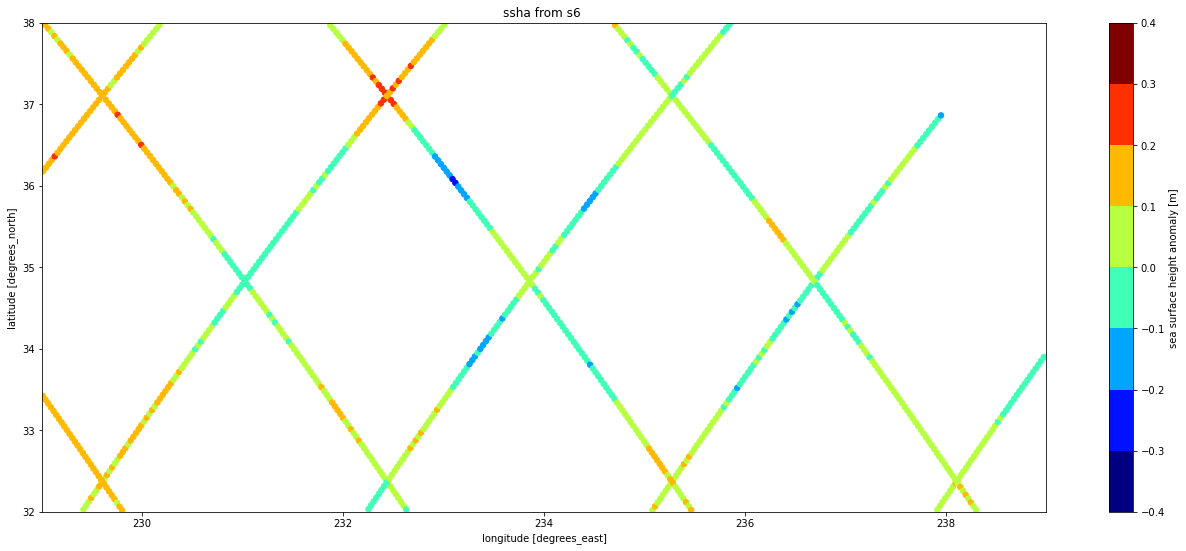

In [14]:
cropped_ds.plot.scatter( y="latitude",
                 x="longitude", 
                 hue="ssha",
                 s=30,
                 vmin=-0.4,
                 vmax=0.4,
                 levels=9, 
                 cmap="jet",
                 aspect=2.5,
                 size=9, )

plt.title(f"ssha from s6 ")
plt.xlim(  lons.start+360, lons.stop+360)
plt.ylim(lats.start,  lats.stop)
plt.show()

In [29]:
ds

<xarray.Dataset>
Dimensions:    (time: 33730)
Coordinates:
    longitude  (time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
    latitude   (time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2021-06-22T11:47:36 ... 2021-07-01T20:39:06
Data variables:
    ssha       (time) float64 dask.array<chunksize=(3373,), meta=np.ndarray>
Attributes: (12/64)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4____SURF_AX_20151008T000000...
    xref_wind_speed_alt:                    S6A_P4_2__WNDL_AX_20151008T000000...
    product_name:                           S6A_P4_2__LR______20210622T114735...
    history:                                2021-06-23 10:01:31 : Creation\n2...
    history_json:                           [{"$schema":"https:\/\/harmony.ea...